# TP 1: California Housing

## Import libraries

In [ ]:
import torch
import sklearn
import numpy as np
import matplotlib.pyplot as plt


## Import modules

In [ ]:
from torch import nn, Tensor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset

## Load the dataset

In [ ]:
housing = fetch_california_housing()

## Get data as numpy arrays

In [ ]:
x = housing['data']
y = housing['target']

## Convert to pytorch tensors

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

## Split in train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

## Normalize the data

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train = torch.from_numpy(np.float32(x_train_scaled))
x_test = torch.from_numpy(np.float32(x_test_scaled))

## Instantiate Linear Regression model

In [ ]:
input_dim = x_train.shape[1]
output_dim = 1

#ideal usar class Linear(nn.Module), ver TP2
model = nn.Linear(input_dim, output_dim)

## Define loss function and optimizer

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Define data class for DataLoader


In [ ]:
class Data(Dataset):
  def __init__(self, x:Tensor, y:Tensor):
    self.x = x_train
    self.y = y_train

    self.len = self.x.shape[0]

  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]

  def __len__(self) -> int:
    return self.len

## Training loop

In [ ]:
# Define DataLoaders and batch size
#   batch_size = 1 => Stochastic GD (SGD)
#   len(x_train) > batch_size > 1 => Mini-batch GD (MGD)
#   batch_size = len(x_train) => Batched GD (GD)

def setNumberAtIndexOrNothing(array, index, value):
  if not np.isnan(value):
    array[index] = value

# Alternativa a class heredando Dataset:
#   train_ft = torch.hstack((x_train, y_train))
#   (en la iteracion se utiliza: x_train, y_train = train_ft[:,:-1],train_ft[:-1,:])

#batch_size = 64
batch_size = 1
train_dataloader = DataLoader(Data(x_train, y_train), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(Data(x_test, y_test), batch_size=batch_size, shuffle=True)


epochs = 200
losses_train = np.repeat(0.0, epochs)
losses_test = np.repeat(0.0, epochs)

for epoch in range(epochs):
  # TODO: Use torch.DataLoader
  for i, (d_x_train, d_y_train) in enumerate(train_dataloader):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    outputs_train = model(d_x_train)

    # Calculate loss
    loss_train = criterion(outputs_train, d_y_train)
    setNumberAtIndexOrNothing(losses_train, epoch, loss_train.item())

    # Update gradients
    loss_train.backward()

    # Update weights
    optimizer.step()

  # NO hace falta utilizar el dataloader en este caso, solo en el train
  for i, (d_x_test, d_y_test) in enumerate(test_dataloader):
    # Validate
    output_test = model(d_x_test)
    loss_test = criterion(output_test, d_y_test)
    setNumberAtIndexOrNothing(losses_test, epoch, loss_test.item())



# print final losses
print(f"Last train loss: {losses_train[-1]}")
print(f"Last test loss: {losses_test[-1]}")

Last train loss: 0.8314501643180847
Last test loss: 0.33306458592414856


## Plot the losses

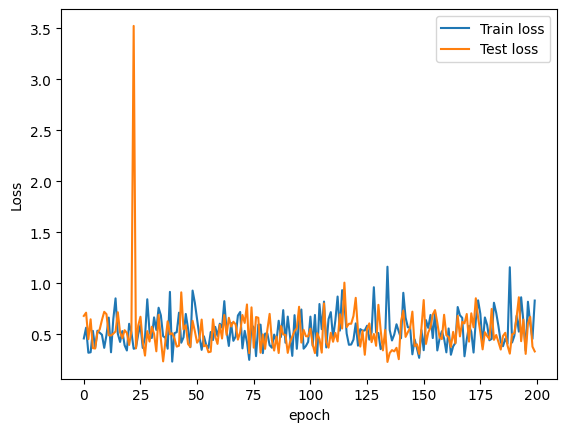

In [ ]:
plt.plot(losses_train, label='Train loss')
plt.plot(losses_test, label='Test loss')
plt.ylabel('Loss')

plt.xlabel('epoch')
plt.legend(loc='best')

## Visialize the model in test

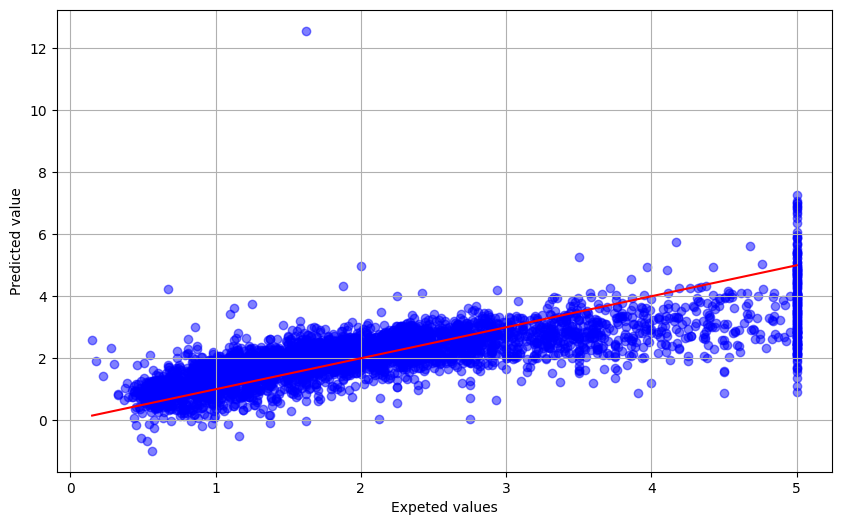

In [ ]:
model.eval()
with torch.no_grad():
  predictions = model(x_test)

predictions = predictions.numpy()
expected = y_test.numpy()

plt.figure(figsize=(10, 6))
plt.scatter(expected, predictions, color='blue', alpha=0.5)
plt.xlabel('Expeted values')
plt.ylabel('Predicted value')
plt.plot([min(expected), max(expected)], [min(expected), max(expected)], color='red')
plt.grid(True)
plt.show()

# TODO: Add conclusion

# Conclusion

En resumen como vimos en la teoria, Sthochastic Gradient Descent (SGD) actualiza los pesos para cada elemento del dataset. Esto hace que genere una rápida convergencia e incremente su fluctuación a diferencia de Batched Gradient Descent (GD).

 En conclusion, SGD posee una gran reducción del uso de la RAM con el costo de procesar mas lentamente al actualizar de a un elemento del dataset. Esto hace que se desaproveche ampliamente el hardware que poseemos, ya que se posee suficiente RAM y CPU. Aunque en caso de que no se posea dicho recurso (RAM), esta deberia ser la ideal.


### Bugs
- Los gráficos se rompen al utilizar batch_size = 1, es raro porque con un batch_size mas grande se soluciona.